In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from dataloader import DataLoader

# Intensities inside the blood pool vs. inside the heart muscle
To study this informally, one can visually compare the histograms of the inner masks (blood) and of the difference outer - inner mask (muscle) by plotting them over one another. 

I perform this study per image, as a heuristical separation would also be done per image. Moreover, I evaluate per patient/scanning sequence, as MR intensities are in general scanning sequence/patient dependent. For this, I had to make a small change to `DataLoader` class.

The results indicate that the intensity distributions are bimodal in general, although not perfectly separable. A well-chosen threshold therefore might provide reasonable results. As choosing a threshold manually is unrealistic, I reverted to Otsu's method (https://en.wikipedia.org/wiki/Otsu%27s_method), which maximizes inter-class variance. See the next experiment.

In addition, I noticed that the outer contours in SC-HF-I-6 might be incorrect (translated), as the inner contour is not a subset of the outer one.

PATIENT #0


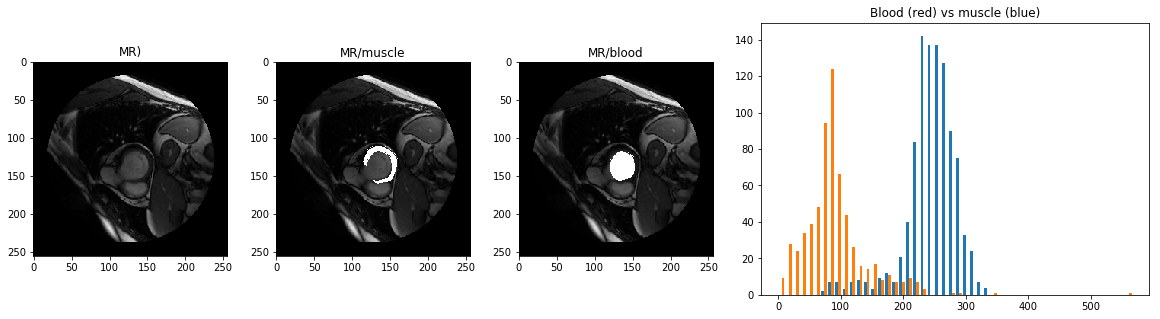

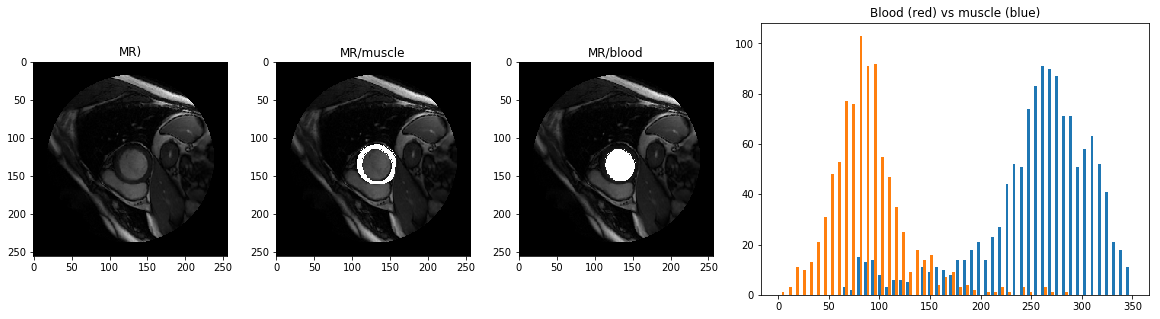

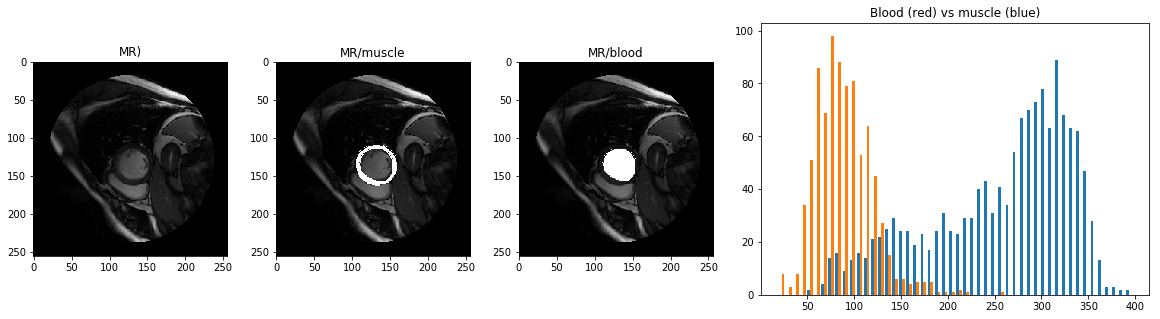

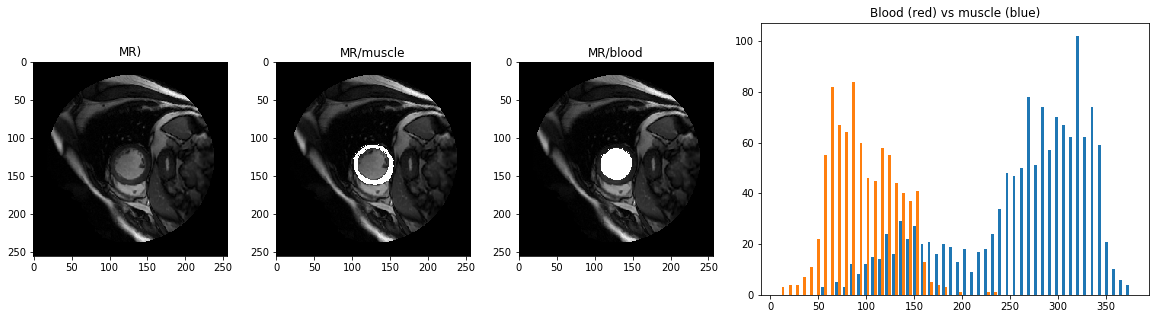

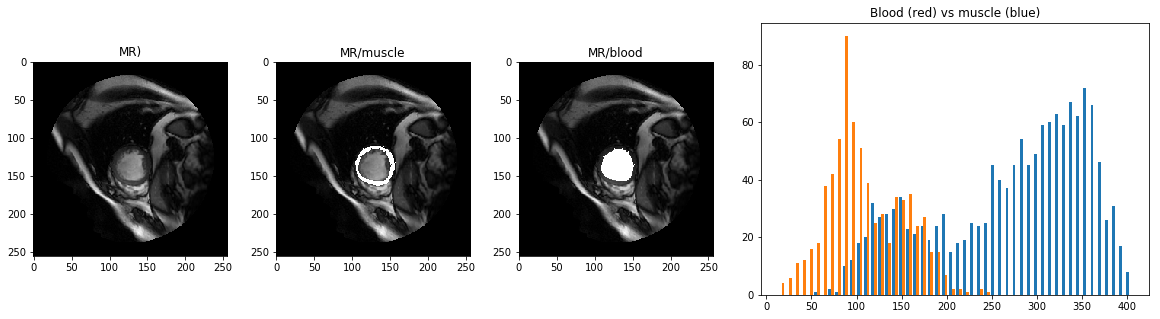

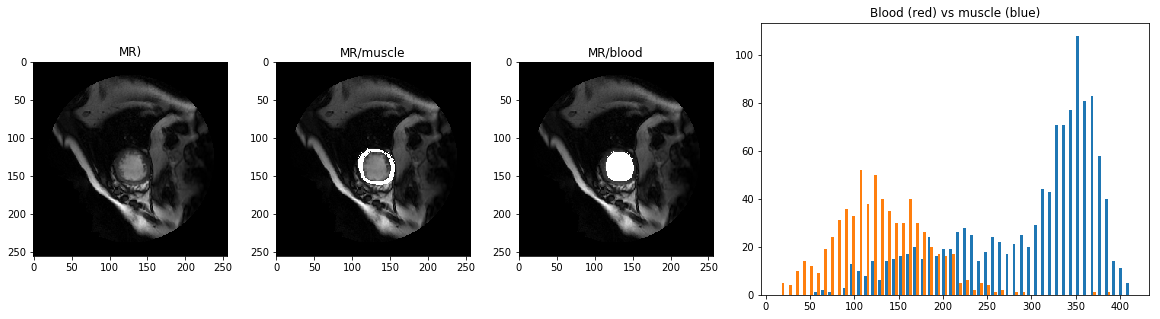

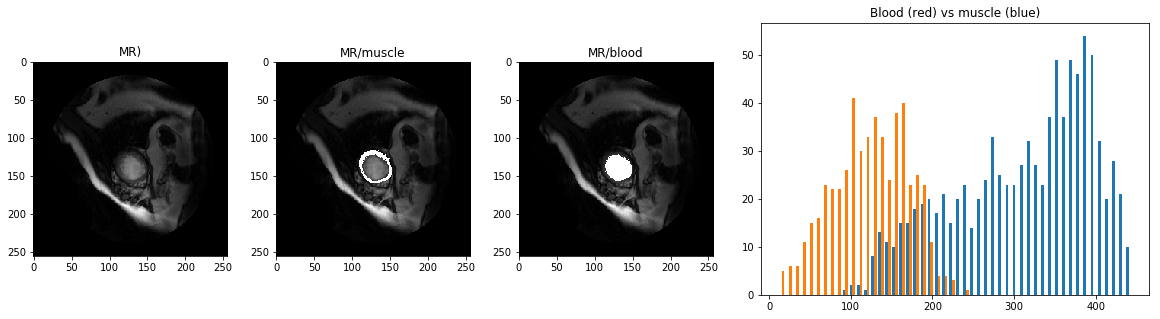

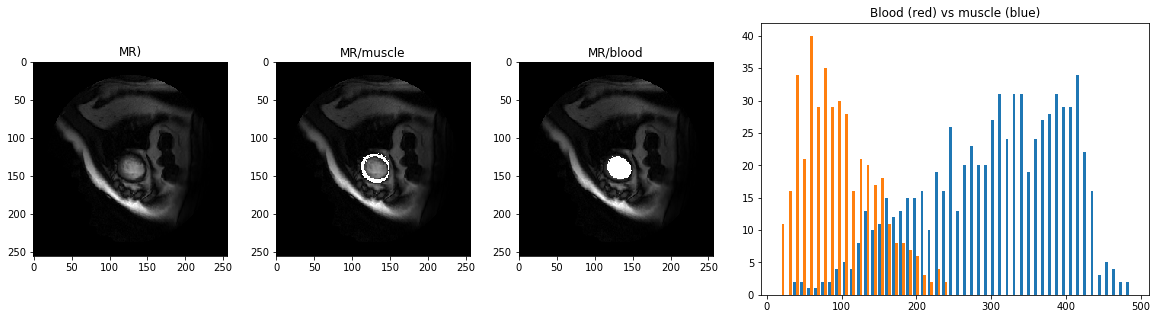

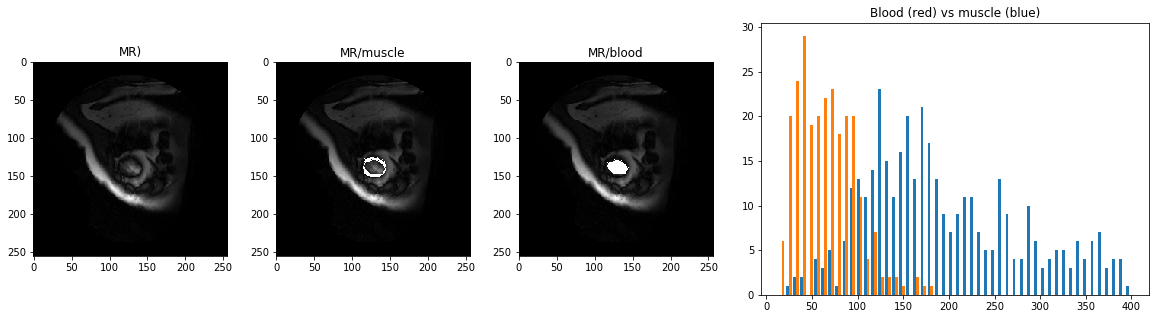

PATIENT #1


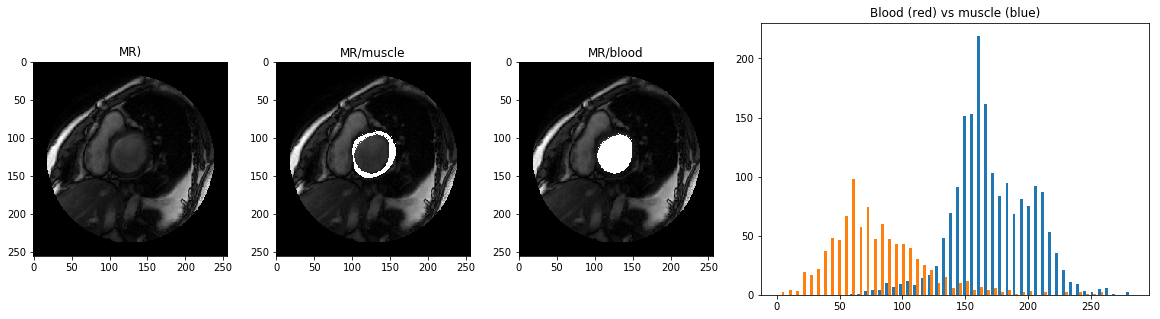

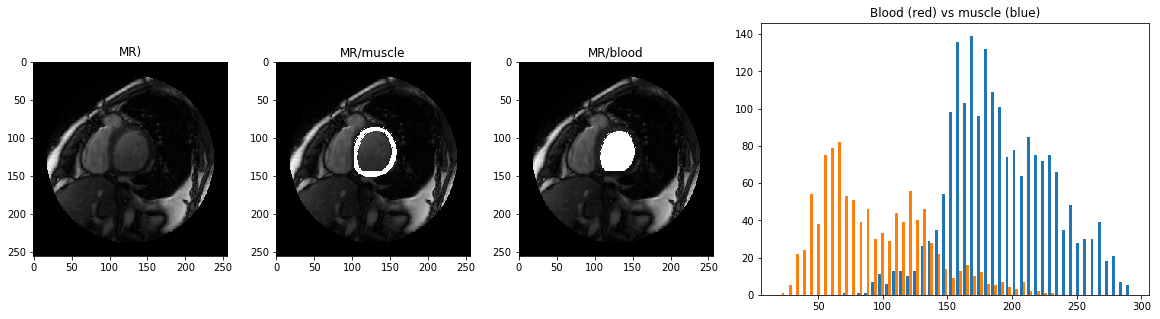

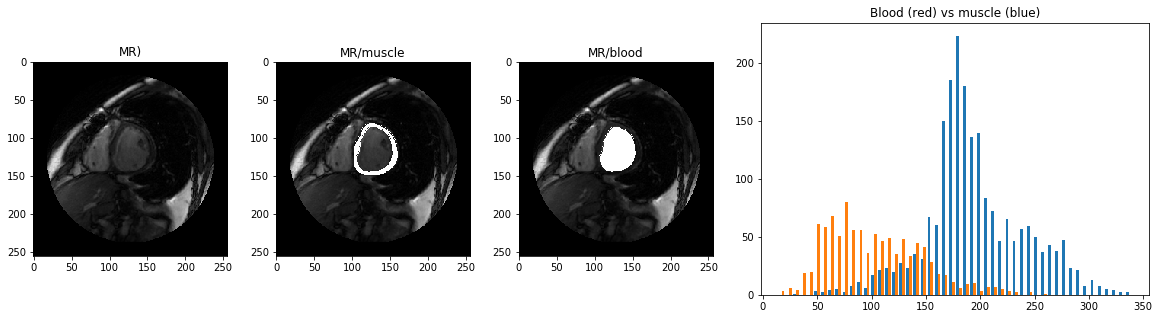

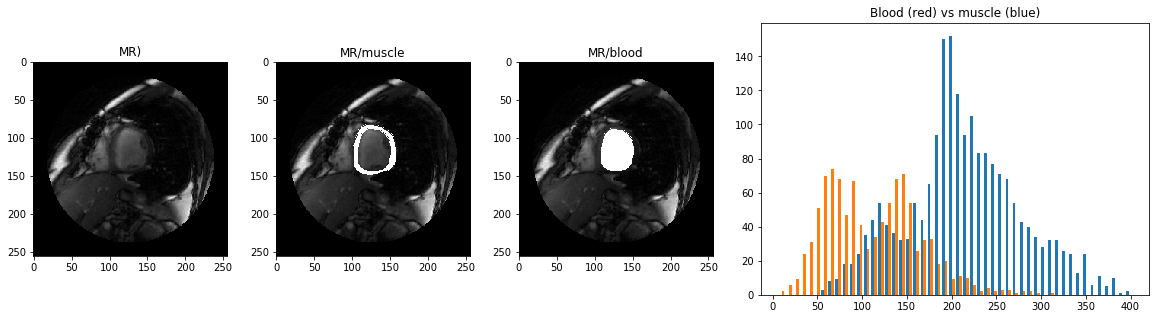

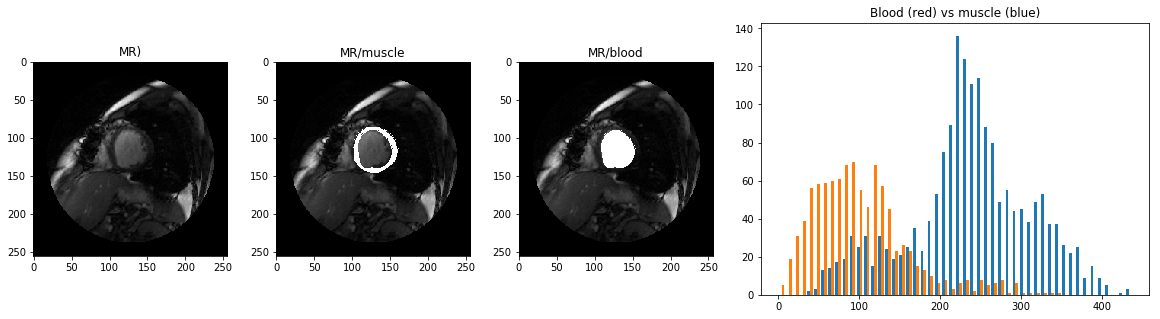

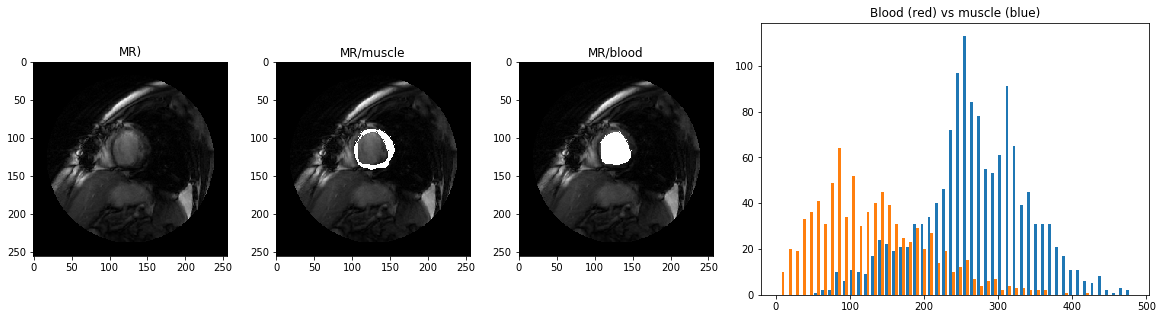

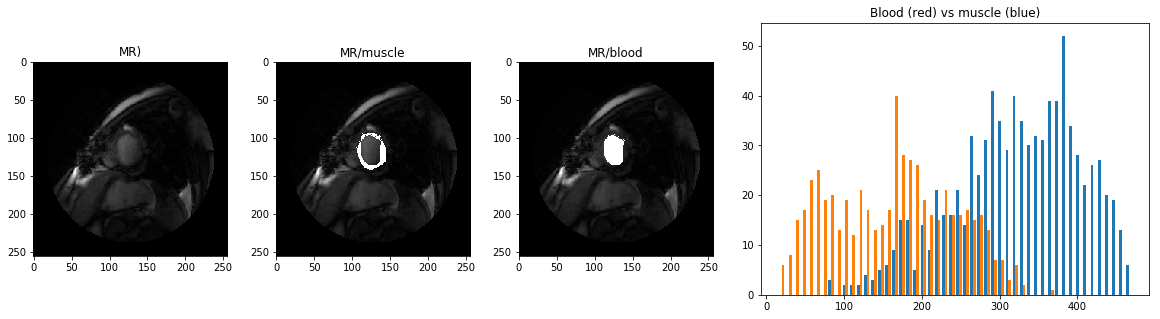

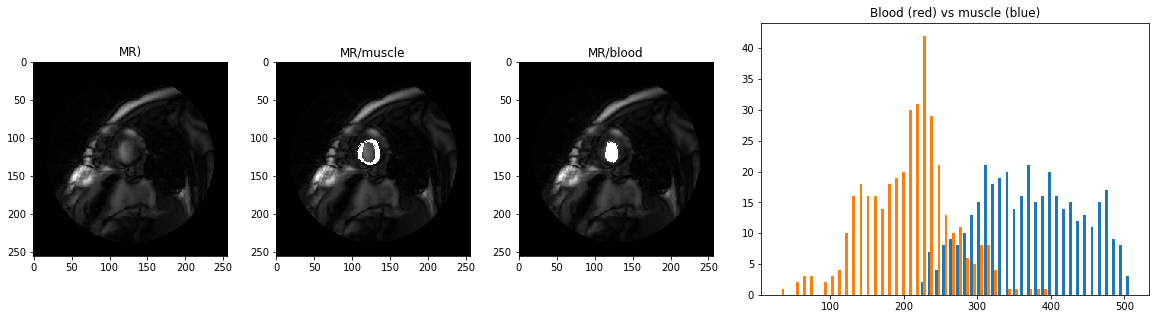

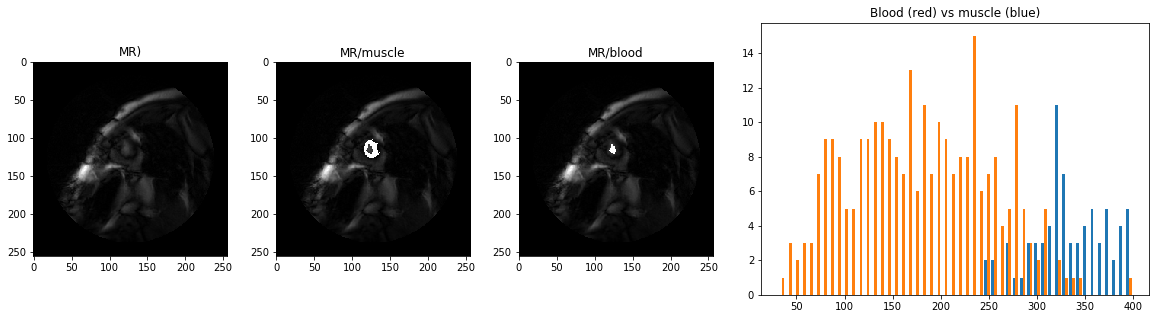

PATIENT #2


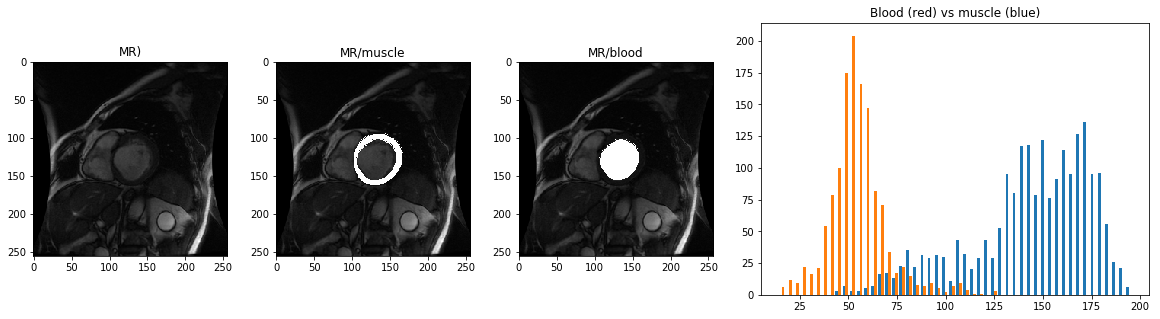

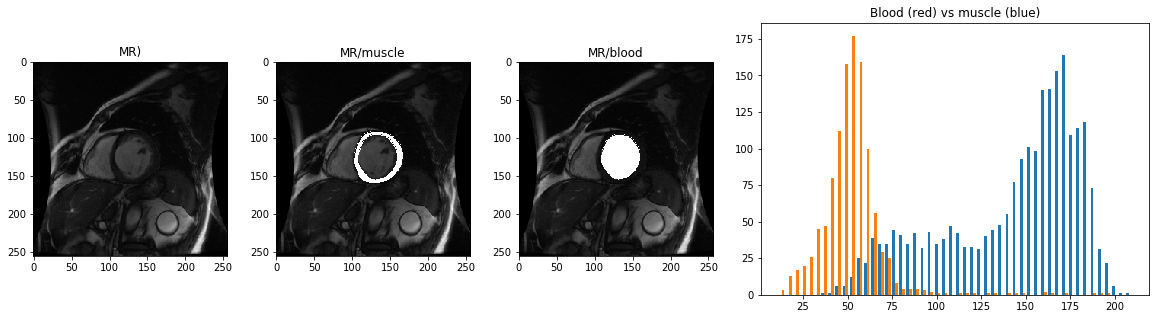

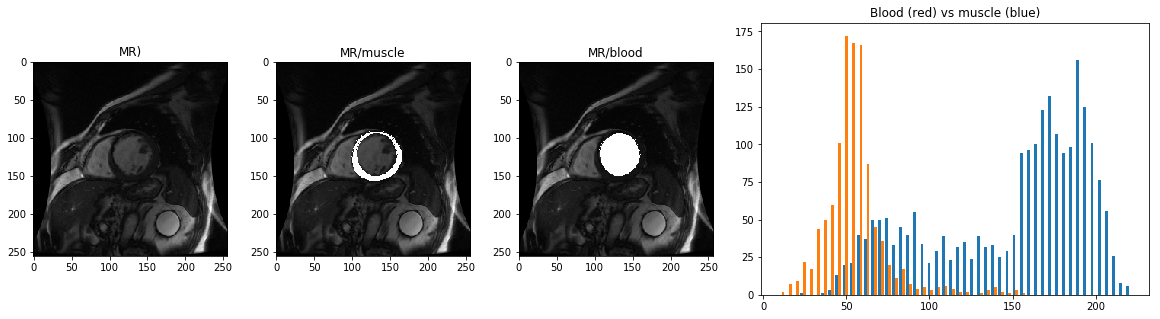

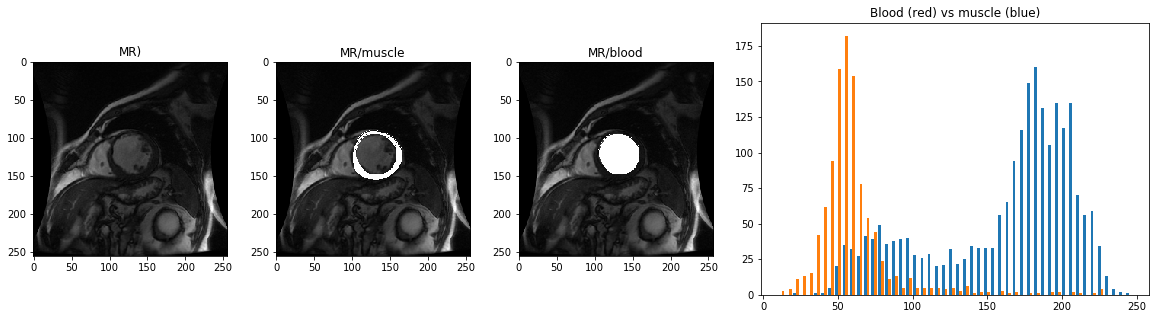

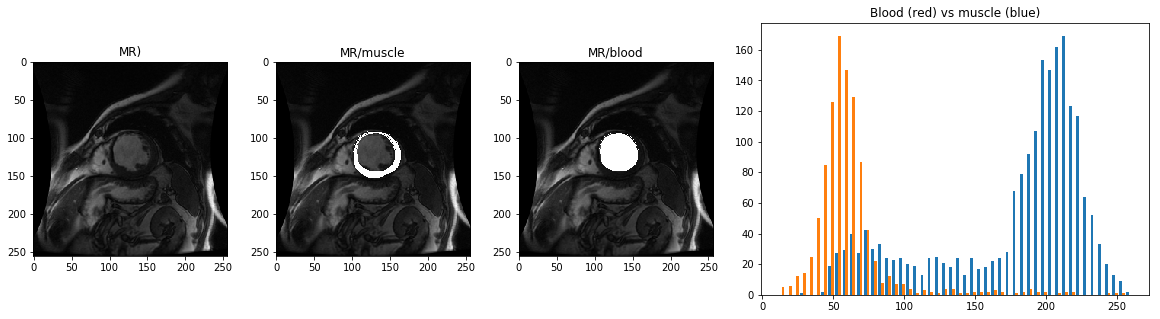

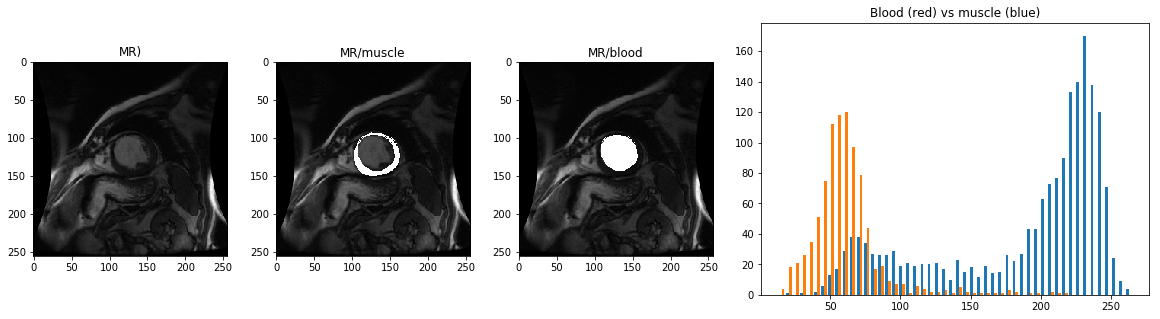

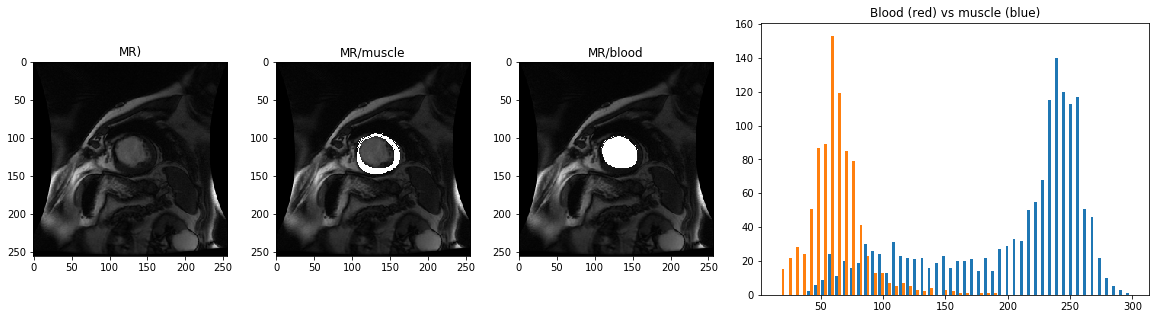

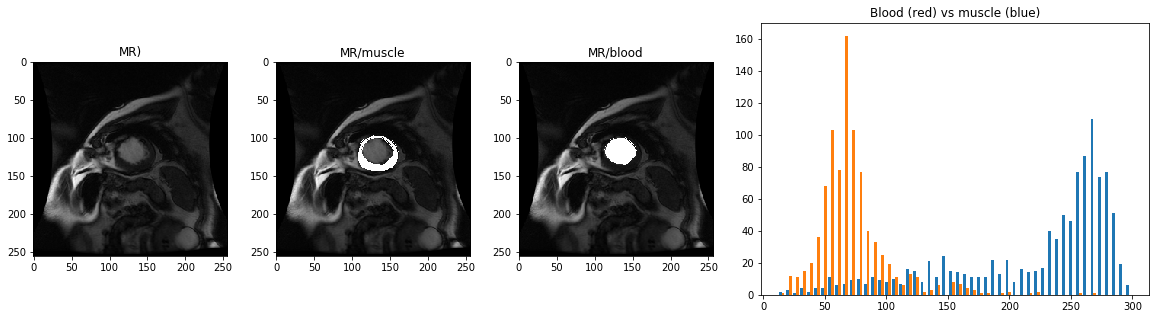

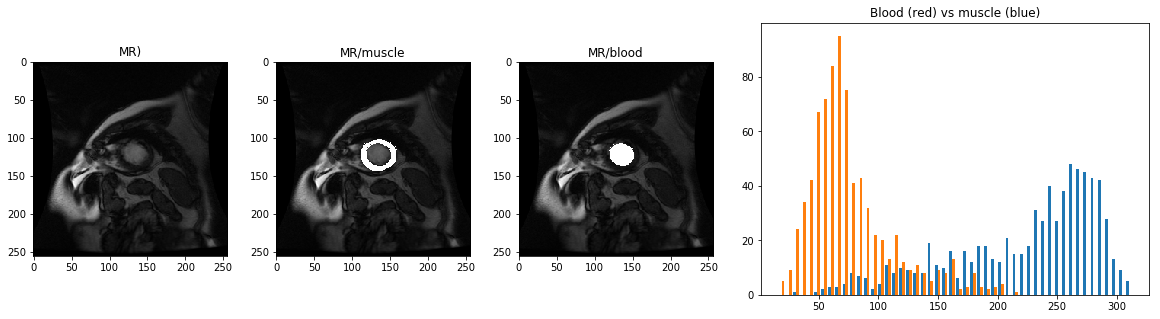

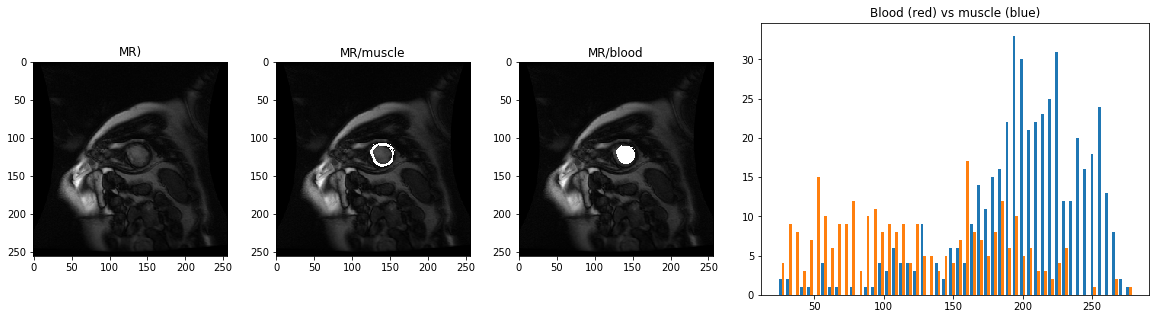

PATIENT #3


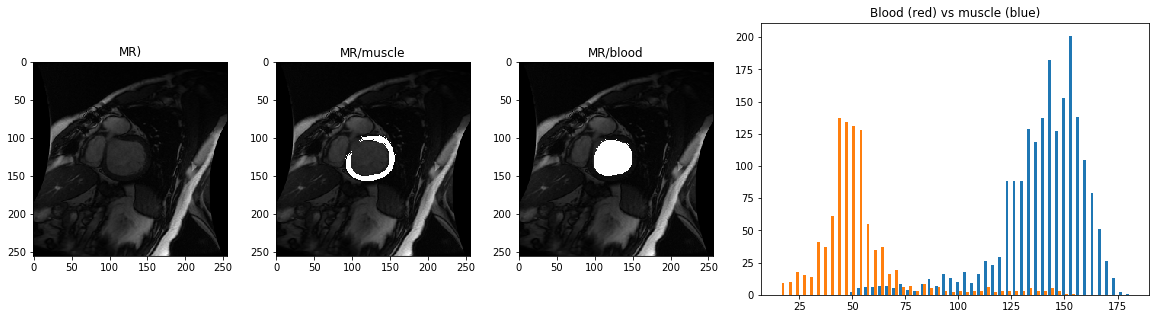

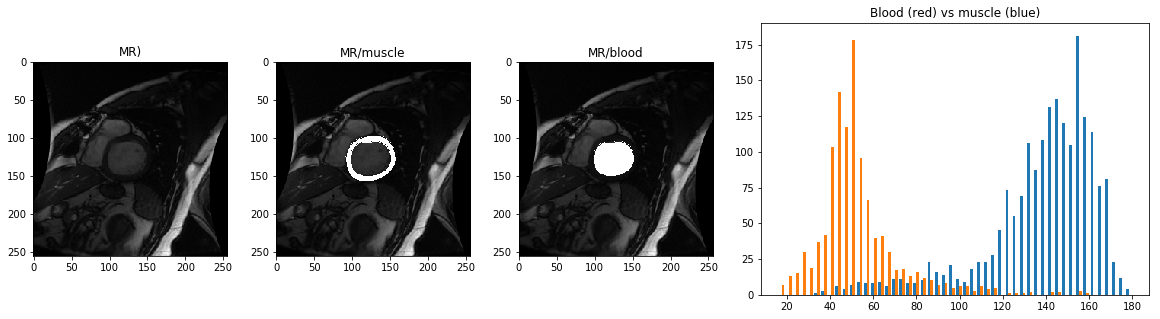

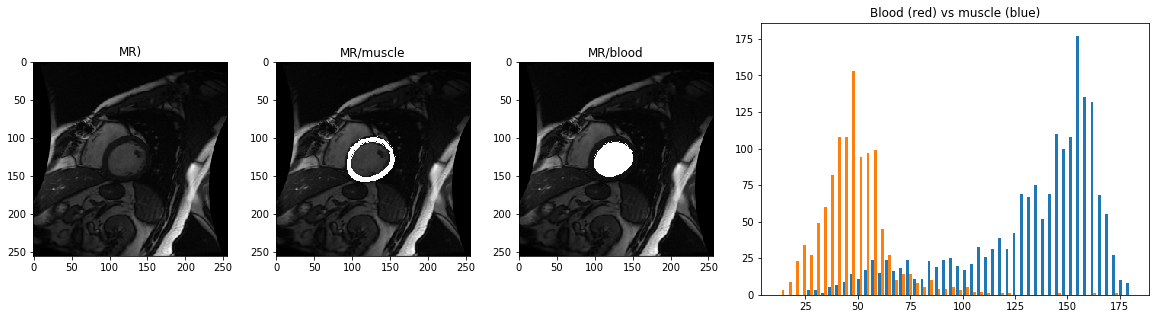

In [ ]:
for patientid in xrange(0, 5):
    print('PATIENT #{:d}'.format(patientid))
    loader = DataLoader('./final_data', 1, True, [patientid])

    for inputs, imasks, omasks in iter(loader.next, None): 
        im = inputs[0]
        inner = imasks[0]
        ring = np.copy(omasks[0])
        ring[inner] = False

        f, axarr = plt.subplots(1, 4, gridspec_kw = {'width_ratios':[1,1,1,2]}, figsize=(20,5))
        axarr[0].imshow(im, cmap="gray"); axarr[0].set_title("MR)")

        imm = np.copy(im)
        imm[ring] = np.max(im)
        axarr[1].imshow(imm, cmap="gray"); axarr[1].set_title("MR/muscle")

        imm = np.copy(im)
        imm[inner] = np.max(im)
        axarr[2].imshow(imm, cmap="gray"); axarr[2].set_title("MR/blood")

        axarr[3].hist([im[inner], im[ring]], bins=50); axarr[3].set_title("Blood (red) vs muscle (blue)")
        plt.show()

# Pixel-wise Otsu's segmentation
In this experiment, I segment blood by Otsu's method (https://en.wikipedia.org/wiki/Otsu%27s_method) applied to the image delimited by the outer contour. To evaluate the results, I compute intersection-over-union with respect to the ground truth. The results are reasonable.

PATIENT #0


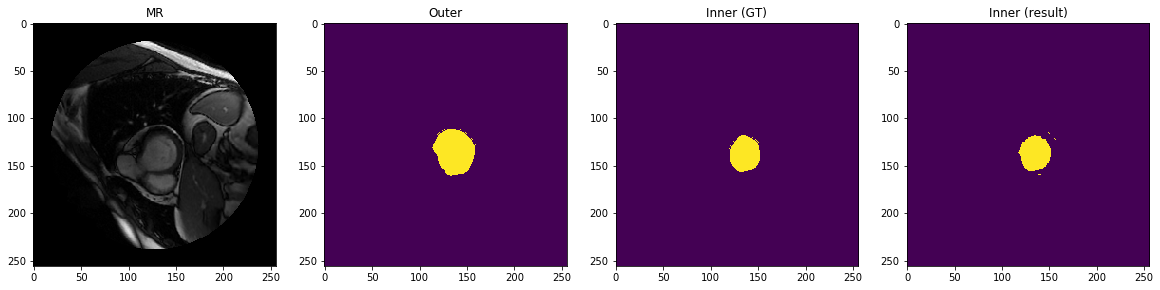

Mean Intersection-over-Union: 0.751436
PATIENT #1


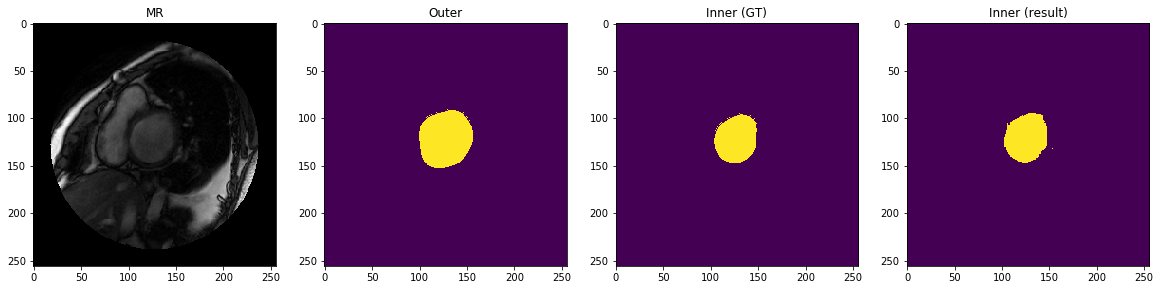

Mean Intersection-over-Union: 0.757650
PATIENT #2


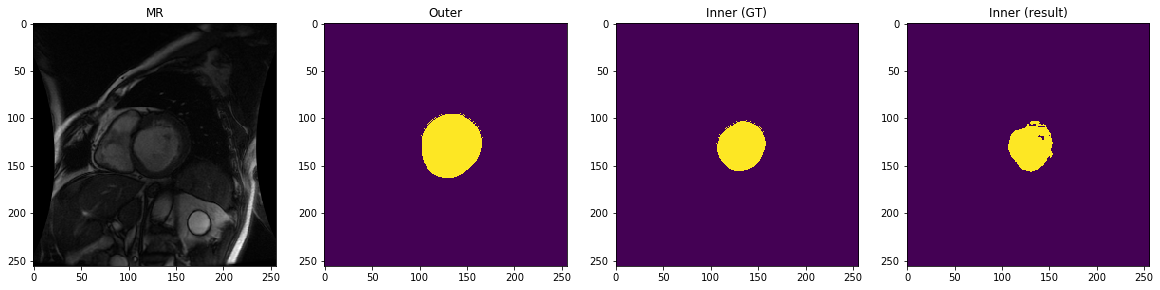

Mean Intersection-over-Union: 0.759181
PATIENT #3


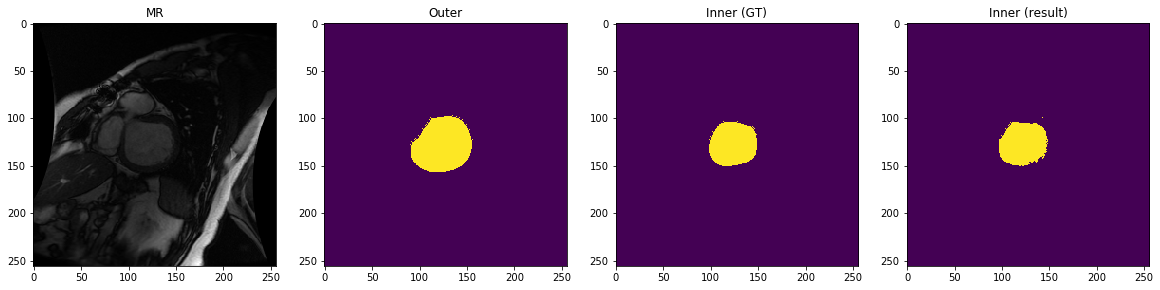

Mean Intersection-over-Union: 0.791528
PATIENT #4


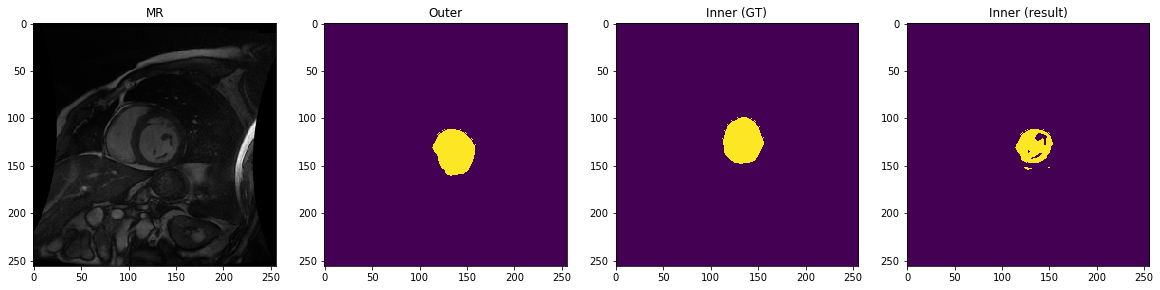

Mean Intersection-over-Union: 0.419481


In [21]:
for patientid in xrange(0, 5):
    print('PATIENT #{:d}'.format(patientid))
    loader = DataLoader('./final_data', 1, True, [patientid])
    ious = []

    for inputs, imasks, omasks in iter(loader.next, None): 
        
        im = (inputs[0].astype(np.float32) / np.max(inputs[0]) * 255).astype(np.uint8)  # cv2 Otsu algorithm can only work in uint8
        inner = imasks[0]
        outer = omasks[0]
        
        # Find threshold in the outer mask and use it to segment inner contour -> inner_otsu
        im_outer_vec = im[outer]
        thr,_ = cv2.threshold(im_outer_vec, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        _,inner_otsu = cv2.threshold(im, thr, 255, cv2.THRESH_BINARY)
        inner_otsu[np.logical_not(outer)] = False
        
        # measure intersection over union
        iou = float(np.sum(np.logical_and(inner, inner_otsu))) / np.sum(np.logical_or(inner, inner_otsu))
        ious.append(iou)
        
        if len(ious) <= 1:
            f, axarr = plt.subplots(1, 4, figsize=(20,5))
            axarr[0].imshow(im, cmap="gray"); axarr[0].set_title("MR")
            axarr[1].imshow(outer); axarr[1].set_title("Outer")
            axarr[2].imshow(inner); axarr[2].set_title("Inner (GT)")
            axarr[3].imshow(inner_otsu); axarr[3].set_title("Inner (result)")
            plt.show()
            
    print('Mean Intersection-over-Union: {:f}'.format(np.mean(ious)))

# Ring-wise Otsu's segmentation
With simple thresholding, one doesn't exploit any spatial information (coherence of tissues). Assuming that the muscle has more or less the same thickness in a slice (not fully realistic, especially in diseases), a quick attempt to fix it is to perform erosion on the outer contour mask to obtain the inner mask. The question is what is the proper thickness...

I tried a simple algorithm: a series of concentric rings is created by eroding the outer mask step by step. For each ring, mean intensity can be computed. The obtained series of intensities is also expected to be bimodal and given to Otsu's method for binarization. In this setting, Otsu will retrieve the intensity of erosion which obtaines the best separation between the two classes.

The results are much better than using the previous pixel-wise segmentation, by about 0.05-0.1 points (with exception of the last patient, who I believe was wrongly annotated).

PATIENT #0


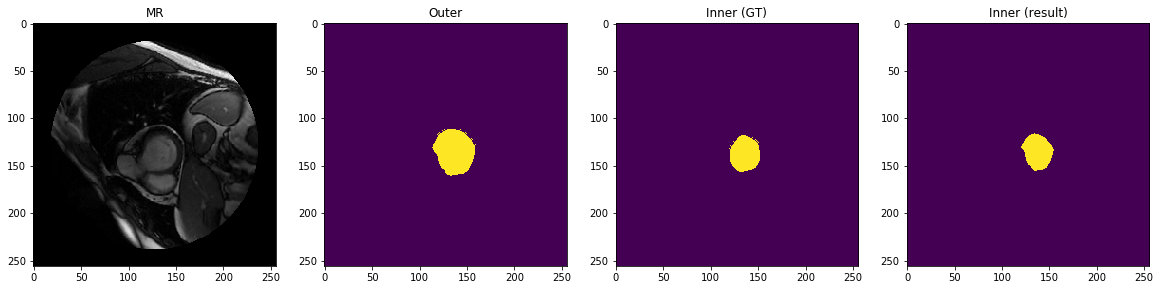

Mean Intersection-over-Union: 0.834944
PATIENT #1


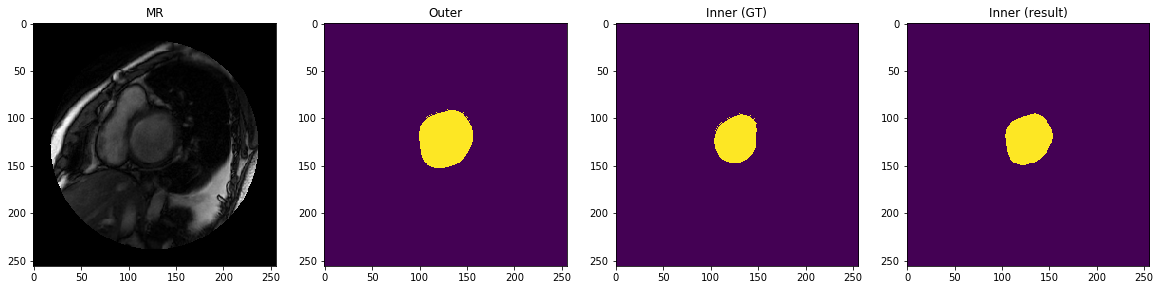

Mean Intersection-over-Union: 0.800840
PATIENT #2


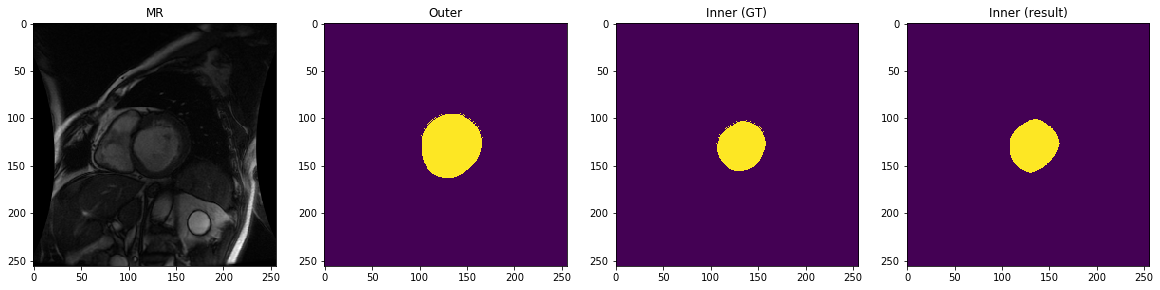

Mean Intersection-over-Union: 0.829592
PATIENT #3


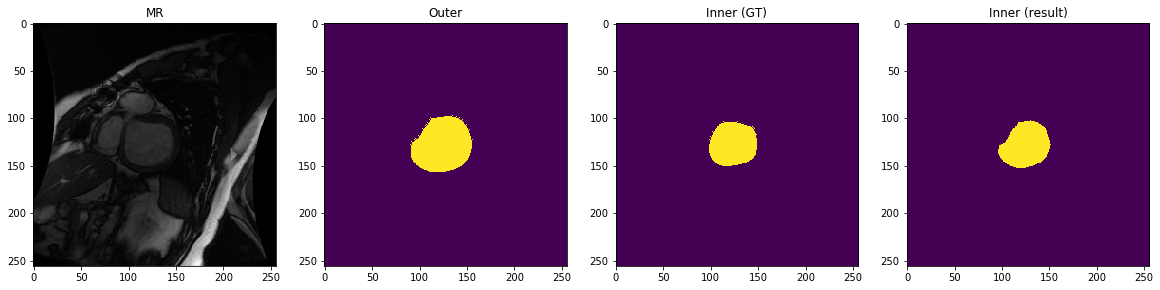

Mean Intersection-over-Union: 0.898079
PATIENT #4


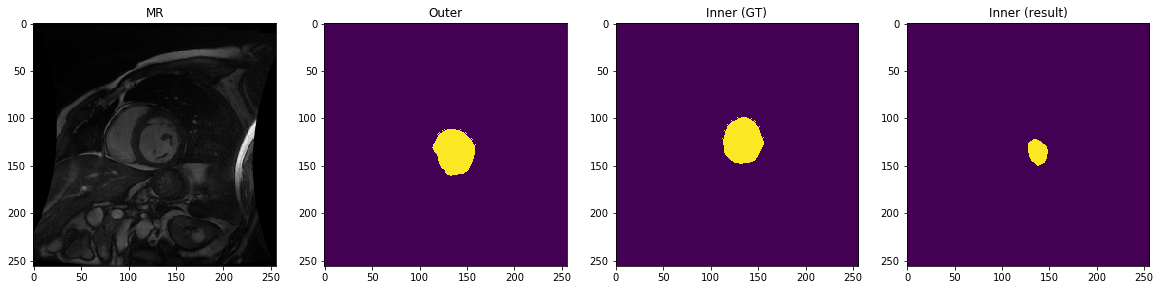

Mean Intersection-over-Union: 0.139603


In [22]:
for patientid in xrange(0, 5):
    print('PATIENT #{:d}'.format(patientid))
    loader = DataLoader('./final_data', 1, True, [patientid])
    ious = []

    for inputs, imasks, omasks in iter(loader.next, None): 
        
        im = (inputs[0].astype(np.float32) / np.max(inputs[0]) * 255).astype(np.uint8)  # cv2 Otsu algorithm can only work in uint8
        inner = imasks[0]
        outer = omasks[0].astype(np.uint8)

        # step-wise erode the outer mask until it disappears and compute the mean intensity of each ring
        kernel = np.ones((3,3),np.uint8)
        outer_eroded = [outer.astype(np.uint8)]
        ring_means = []
        while np.sum(outer_eroded[-1]) > 0:
            erosion = cv2.erode(outer_eroded[-1], kernel)
            ring = (outer_eroded[-1] - erosion).astype(np.bool)
            ring_means.append(np.mean(im[ring]))
            outer_eroded.append(erosion)
            
        # Find threshold in the series of ring intensities and use it to choose the respective eroded mask
        thr,binarized = cv2.threshold(np.array(ring_means,np.uint8), 0, 255, cv2.THRESH_OTSU)
        idx = np.nonzero(binarized == 255)[0][0]
        inner_otsu = outer_eroded[idx-1]
        
        # measure intersection over union
        iou = float(np.sum(np.logical_and(inner, inner_otsu))) / np.sum(np.logical_or(inner, inner_otsu))
        ious.append(iou)
        
        if len(ious) <= 1:
            f, axarr = plt.subplots(1, 4, figsize=(20,5))
            axarr[0].imshow(im, cmap="gray"); axarr[0].set_title("MR")
            axarr[1].imshow(outer); axarr[1].set_title("Outer")
            axarr[2].imshow(inner); axarr[2].set_title("Inner (GT)")
            axarr[3].imshow(inner_otsu); axarr[3].set_title("Inner (result)")
            plt.show()
            
    print('Mean Intersection-over-Union: {:f}'.format(np.mean(ious)))